<a href="https://colab.research.google.com/github/gregorio-saporito/hate-speech-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining and Sentiment Analysis: Hate Speech Detection
Gregorio Luigi Saporito - DSE (2020-2021)

### Reproducibility

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(123)
import random as rn
rn.seed(123)

### Libraries

In [2]:
!pip install text-preprocessing
!pip install tweet-preprocessor
!pip install -U nltk[twitter]
!pip install joblib

Requirement already up-to-date: nltk[twitter] in /usr/local/lib/python3.7/dist-packages (3.6.2)


In [3]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import preprocessor as p
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number, remove_punctuation, remove_whitespace, normalize_unicode, lemmatize_word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from tqdm import tqdm
from sklearn import utils
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statistics as st
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Upload the data to session storage
Upload here below the __labeled_data.csv__ file. The labels correspond to
- 0: hate speech
- 1: offensive language
- 2: neither

In [5]:
# upload here the .csv file "labeled_data.csv"
uploaded = files.upload()

In [6]:
# read the csv file, select the columns of interest, and rename them
fields = ['Unnamed: 0', 'class', 'tweet']
raw = pd.read_csv('labeled_data.csv', usecols=fields)\
  .rename(columns={"Unnamed: 0": "id", "class": "label"})

### Inspect the data

In [7]:
# snapshot of the first rows
raw.head()

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
# size of the dataset
raw.shape

(24783, 3)

In [9]:
# inspect the presence of missing values
print(
    'Check for null values\n' +
    str(raw.isnull().sum()) + '\n'
    'Check for na values\n' +
    str(raw.isna().sum())
)

Check for null values
id       0
label    0
tweet    0
dtype: int64
Check for na values
id       0
label    0
tweet    0
dtype: int64


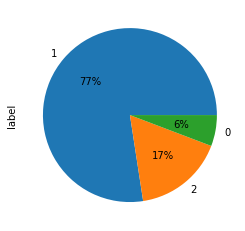

In [10]:
# inspect the classes' frequency
raw['label'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.show()

### Preprocessing text

In [11]:
# normalise tags, URLS, emoji, and smiley
# the hashtags are left out because they could contain hate speech to detect
p.set_options(p.OPT.MENTION, p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
raw['normalised'] = [p.tokenize(x) for x in raw['tweet']]

# Preprocess text using custom preprocess functions in the pipeline
def preprocess_txt(x):
  preprocess_functions = [to_lower, expand_contraction, remove_number, remove_punctuation,
                          remove_whitespace, normalize_unicode, lemmatize_word]
  preprocessed_text = preprocess_text(x, preprocess_functions)
  return preprocessed_text.replace("rt ", "").strip()

raw['cleaned'] = [preprocess_txt(x) for x in raw['normalised']]

### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(raw['cleaned'], raw['label'], test_size=0.1, random_state=123)

### Doc2vec Custom Transformer

In [13]:
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, dm=1, size=1, window=1):
        self.d2v_model = None
        self.size = size
        self.window = window
        self.dm = dm

    def fit(self, raw_documents, y=None):
        # Initialize model
        self.d2v_model = Doc2Vec(workers=1, seed=123)
        # Tag docs
        tagged_documents = []
        for index, row in raw_documents.iteritems():
            tag = '{}_{}'.format("type", index)
            tokens = row.split()
            tagged_documents.append(TaggedDocument(words=tokens, tags=[tag]))
        # Build vocabulary
        self.d2v_model.build_vocab(tagged_documents)
        # Train model
        self.d2v_model.train(tagged_documents, total_examples=len(tagged_documents), epochs=self.d2v_model.epochs)
        return self

    def transform(self, raw_documents):
        X = []
        for index, row in raw_documents.iteritems():
            X.append(self.d2v_model.infer_vector(row))
        X = pd.DataFrame(X, index=raw_documents.index)
        return X
        
    def fit_transform(self, raw_documents, y=None):
        self.fit(raw_documents)
        return self.transform(raw_documents)

### Sentiment Custom Transformer

In [14]:
class SentimentTransformer( BaseEstimator, TransformerMixin ):
    
    # Class Constructor 
    def __init__( self ):
        return
    
    # Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
        
    # Method that describes what we need this transformer to do i.e.
    # returning length, digits and punctuations in the 'text' column in data frame
    def transform( self, X, y = None ):
      sia = SentimentIntensityAnalyzer()

      f           = pd.DataFrame()
      f['neg']    = [sia.polarity_scores(x)['neg'] for x in X]
      f['neu']    = [sia.polarity_scores(x)['neu'] for x in X]
      f['pos']    = [sia.polarity_scores(x)['pos'] for x in X]
      return f[['neg','neu','pos']]

### Dense Transformer

In [15]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

### 1) Latent Semantic Analysis (LSA) and Logistic Classifier

In [16]:
# vectoriser
tfidf = TfidfVectorizer(sublinear_tf=True, use_idf=True).fit_transform(X_train)
# check the shape
print('TF-IDF shape: ' + str(tfidf.shape))

TF-IDF shape: (22304, 19165)


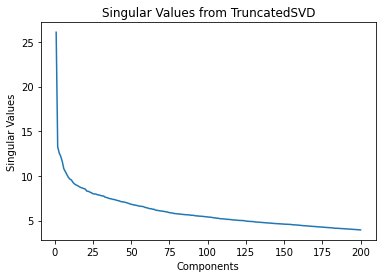

In [17]:
# TruncatedSVD
svd = TruncatedSVD(n_components=200, random_state=123).fit(tfidf)
# plot singular values to have an idea of how many components to select
fig = plt.figure()
ax = plt.axes()
ax.plot(range(1,201), svd.singular_values_)
plt.title('Singular Values from TruncatedSVD')
plt.xlabel('Components')
plt.ylabel('Singular Values')
plt.show()

In [18]:
# build pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
    ('lsa', TruncatedSVD(random_state=123)),
    ('logistic', LogisticRegression(max_iter=10000, class_weight='balanced', random_state=123)),
])

# test some components to select
param_grid = {'lsa__n_components': [100, 1000, 2000]}

log_grid = GridSearchCV(pipe, 
                        param_grid=param_grid,
                        scoring="balanced_accuracy",
                        verbose=3,
                        n_jobs=1,
                        cv = 3)

fitted = log_grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(log_grid.best_params_))
print("Best accuracy: {}\n".format(log_grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] lsa__n_components=100 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... lsa__n_components=100, score=0.767, total=   3.5s
[CV] lsa__n_components=100 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ............... lsa__n_components=100, score=0.761, total=   3.5s
[CV] lsa__n_components=100 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV] ............... lsa__n_components=100, score=0.771, total=   3.6s
[CV] lsa__n_components=1000 ..........................................
[CV] .............. lsa__n_components=1000, score=0.795, total=  37.2s
[CV] lsa__n_components=1000 ..........................................
[CV] .............. lsa__n_components=1000, score=0.800, total=  37.4s
[CV] lsa__n_components=1000 ..........................................
[CV] .............. lsa__n_components=1000, score=0.805, total=  37.4s
[CV] lsa__n_components=2000 ..........................................
[CV] .............. lsa__n_components=2000, score=0.797, total= 1.6min
[CV] lsa__n_components=2000 ..........................................
[CV] .............. lsa__n_components=2000, score=0.797, total= 1.6min
[CV] lsa__n_components=2000 ..........................................
[CV] .............. lsa__n_components=2000, score=0.803, total= 1.7min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.9min finished


Best Parameters: {'lsa__n_components': 1000}

Best accuracy: 0.8001275086013887

Finished.


In [19]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.8086370644663581

### 2) Rich Feature Extraction (mixed), Feature Selection, Regularisation, and Logistic Classifier
A richer feature extraction is considered including the:
- TF-IDF transformer
- Doc2vec custom transformer
- Sentiment polarity custom transformer

In [20]:
# build pipeline
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif)),
  ('to_dense', DenseTransformer()),
  ('scale', StandardScaler()),
  ('logistic', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=123, penalty='l2'))
])

# test some parameters (number of features and regularisation)
param_grid = {'select__k': [200, 300, 500]
}

log_grid = GridSearchCV(pipe, 
                        param_grid=param_grid,
                        scoring="balanced_accuracy",
                        verbose=3,
                        n_jobs=1,
                        cv = 3)

fitted = log_grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(log_grid.best_params_))
print("Best accuracy: {}\n".format(log_grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] select__k=200 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... select__k=200, score=0.787, total=  59.5s
[CV] select__k=200 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.5s remaining:    0.0s


[CV] ....................... select__k=200, score=0.778, total=  58.8s
[CV] select__k=200 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV] ....................... select__k=200, score=0.799, total=  57.8s
[CV] select__k=300 ...................................................
[CV] ....................... select__k=300, score=0.806, total= 1.1min
[CV] select__k=300 ...................................................
[CV] ....................... select__k=300, score=0.792, total= 1.1min
[CV] select__k=300 ...................................................
[CV] ....................... select__k=300, score=0.809, total= 1.0min
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.785, total= 1.3min
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.787, total= 1.2min
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.797, total= 1.3min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  9.9min finished


Best Parameters: {'select__k': 300}

Best accuracy: 0.8022918597875366

Finished.


In [21]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.8024294031581304

### 3) Random Forest

In [22]:
# build pipeline
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif)),
  ('tree', RandomForestClassifier(n_estimators=50, random_state=123))
])

# test some parameters
param_grid = {'select__k': [300, 500]}

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring="balanced_accuracy",
                    verbose=3,
                    n_jobs=1,
                    cv = 3)

fitted = grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(grid.best_params_))
print("Best accuracy: {}\n".format(grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] select__k=300 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... select__k=300, score=0.573, total= 1.0min
[CV] select__k=300 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] ....................... select__k=300, score=0.554, total= 1.1min
[CV] select__k=300 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV] ....................... select__k=300, score=0.574, total= 1.0min
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.551, total= 1.0min
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.539, total= 1.0min
[CV] select__k=500 ...................................................
[CV] ....................... select__k=500, score=0.557, total= 1.0min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.2min finished


Best Parameters: {'select__k': 300}

Best accuracy: 0.5669822999803182

Finished.


In [23]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.5684040730580847

### 4) XGBoost


In [24]:
# build pipeline
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif, k=300)),
  ('to_dense', DenseTransformer()),
  ('scale', StandardScaler()),
  ('xgb',  XGBClassifier(random_state=123, objective= 'multi:softprob',tree_method='hist'))
])

# test some parameters
param_grid = {'xgb__max_depth': [3, 6]}

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring="balanced_accuracy",
                    verbose=3,
                    n_jobs=1,
                    cv = 3)

fitted = grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(grid.best_params_))
print("Best accuracy: {}\n".format(grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] xgb__max_depth=3 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... xgb__max_depth=3, score=0.647, total=  59.6s
[CV] xgb__max_depth=3 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.6s remaining:    0.0s


[CV] .................... xgb__max_depth=3, score=0.640, total=  59.2s
[CV] xgb__max_depth=3 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV] .................... xgb__max_depth=3, score=0.670, total=  59.4s
[CV] xgb__max_depth=6 ................................................
[CV] .................... xgb__max_depth=6, score=0.674, total= 1.2min
[CV] xgb__max_depth=6 ................................................
[CV] .................... xgb__max_depth=6, score=0.669, total= 1.2min
[CV] xgb__max_depth=6 ................................................
[CV] .................... xgb__max_depth=6, score=0.687, total= 1.2min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.5min finished


Best Parameters: {'xgb__max_depth': 6}

Best accuracy: 0.6765121291593603

Finished.


In [25]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.6778559448255498

### 5) Support Vector Machine

In [26]:
# support vector machine
pipe = Pipeline([
  ('extract',
    FeatureUnion([
      ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
      ('doc2vec', Doc2VecTransformer()),
      ('sentiment', SentimentTransformer())
    ])),
  ('select', SelectKBest(score_func = f_classif, k=300)),
  ('to_dense', DenseTransformer()),
  ('scale', StandardScaler()),
  ('svc',  SVC(random_state=123))
])

# test some parameters
param_grid = {'svc__class_weight': ['balanced', 'None']}

grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    scoring="balanced_accuracy",
                    verbose=3,
                    n_jobs=1,
                    cv = 3)

fitted = grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters: {}\n".format(grid.best_params_))
print("Best accuracy: {}\n".format(grid.best_score_))
print("Finished.")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] svc__class_weight=balanced ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... svc__class_weight=balanced, score=0.769, total= 2.9min
[CV] svc__class_weight=balanced ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV] .......... svc__class_weight=balanced, score=0.771, total= 2.9min
[CV] svc__class_weight=balanced ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s


[CV] .......... svc__class_weight=balanced, score=0.790, total= 2.8min
[CV] svc__class_weight=None ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'None'

  FitFailedWarning)


[CV] ................ svc__class_weight=None, score=nan, total=  32.9s
[CV] svc__class_weight=None ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'None'

  FitFailedWarning)


[CV] ................ svc__class_weight=None, score=nan, total=  32.2s
[CV] svc__class_weight=None ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'None'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.3min finished


[CV] ................ svc__class_weight=None, score=nan, total=  32.3s
Best Parameters: {'svc__class_weight': 'balanced'}

Best accuracy: 0.776530984015949

Finished.


In [27]:
# final evaluation after parameter tuning
y_pred = fitted.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.7679893392548744

### Best Performing Model: Latent Semantic Analysis with Logistic Classifier

In [16]:
# build pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
    ('lsa', TruncatedSVD(random_state=123, n_components=1000)),
    ('logistic', LogisticRegression(max_iter=10000, class_weight='balanced', random_state=123)),
])

model = pipe.fit(X_train, y_train)

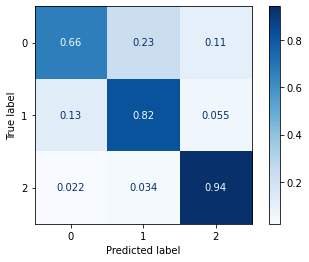

In [18]:
plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.show()

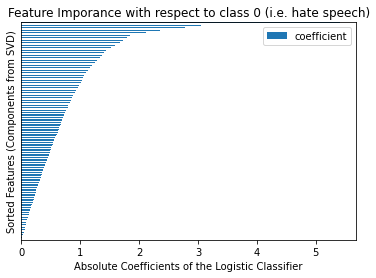

In [71]:
# explore the most important components (absolute value) for the classification problem wrt to class 0 (i.e. hate speech)
results = pd.DataFrame(
    {'coefficient': abs(model['logistic'].coef_[0,:])}
)

results.sort_values(by='coefficient', ascending=True).plot.barh()
ax = plt.gca()
ax.axes.yaxis.set_ticks([])
plt.title('Feature Imporance with respect to class 0 (i.e. hate speech)')
plt.xlabel("Absolute Coefficients of the Logistic Classifier")
plt.ylabel("Sorted Features (Components from SVD)")
plt.show()

In [84]:
# add weight terms (they sum to 1) for each component from SVD based on the coefficients
results = results.assign(weight=lambda x: x.coefficient / x.coefficient.sum())

In [113]:
# now we need the tf-idf matrix with the original features
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(X_train)
#convert it to dense format
densetf = pd.DataFrame(tfidf.toarray())

In [104]:
print(results.shape)
# rows obs and cols features
print(densetf.shape)

(1000, 2)
(22304, 19165)


In [112]:
# now we need the matrix of correlations of the original features with components
# shape of components
model['lsa'].components_.shape

(1000, 19165)